# How Gamma and Poisson relate one another

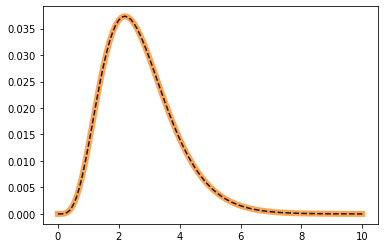

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import gamma, poisson

# Grid approach
lbds = np.linspace(0, 10, 101)
alpha, beta = 1.4, 1  # 1.4 goals per match, t=1
prior = gamma(alpha, scale=1/beta).pdf(lbds)
k, t = 4, 1
likes = poisson(lbds).pmf(k)   # likelihood France scoring 4 under each lambda hypothesis
posterior = prior * likes
posterior /= posterior.sum()

ax = pd.Series(posterior, index=lbds).plot(
    color="C1", lw=6, alpha=.7
)

# Conjugate approach
beta += t
posterior = gamma(alpha+k, scale=1/beta).pdf(lbds)
posterior /= posterior.sum()

ax = pd.Series(posterior, index=lbds).plot(
    ls="--", color="0.1"
)

# Beta vs Binomial

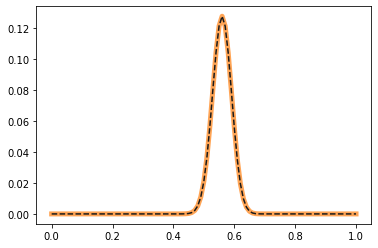

In [2]:
from scipy.stats import binom, beta
import pandas as pd
import numpy as np
hs = np.linspace(0, 1, 101)  # we try to find the probability of the coin
prior = np.ones(101) / 101  # Start with a flat prior, same as beta(1, 1)

# Observations
successes, trials = 140, 250
likes = binom.pmf(successes, trials, hs)
posterior = likes / likes.sum()
pd.Series(posterior, index=hs).plot(
    color="C1", lw=5, alpha=.7
)

# Now with beta
posterior = beta.pdf(hs, 141, 111)
posterior /= posterior.sum()
pd.Series(posterior, index=hs).plot(
    color="0.1", ls="--"
);

# Comparing Sellers Using a Beta Distribution

The expected value is: 0.7833333333333371
The MAP is: 0.79
The CI is: [0.6900000000000001, 0.86]
The expected value is: 0.7833333333333334
The MAP is: 0.78
The CI is: [0.76, 0.81]


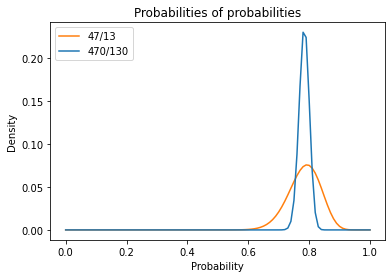

In [3]:
from scipy.stats import beta
import matplotlib.pyplot as plt
from py_scripts.common import QuantitiesOfInterest
s1 = [47, 13]
s2 = [470, 130]
xs = np.linspace(0, 1, 101)

sellers = list()

for seller in (s1, s2):
    seller = beta.pdf(xs, seller[0], seller[1])
    seller /= seller.sum()
    QuantitiesOfInterest(pd.Series(seller, index=xs)).run()
    sellers.append(seller)

seller_1, seller_2 = sellers

fig, ax = plt.subplots()
ax.plot(xs, seller_1, color="C1", label="47/13")
ax.plot(xs, seller_2, color="C0", label="470/130")
ax.set_title("Probabilities of probabilities")
ax.set_ylabel("Density")
ax.set_xlabel("Probability")
ax.legend();

# Multinomial and Dirichlet distributions

The expected value is: 0.44173661492574634
The MAP is: 0.45
The CI is: [0.2, 0.7]
The expected value is: 0.33100550109713617
The MAP is: 0.25
The CI is: [0.1, 0.6]
The expected value is: 0.22725788397711758
The MAP is: 0.15
The CI is: [0.05, 0.5]
**************************************************
Dirichlet Approach
The expected value is: 0.4395959587971648
The MAP is: 0.43
The CI is: [0.18, 0.71]
The expected value is: 0.33983431537375725
The MAP is: 0.29
The CI is: [0.11, 0.62]
The expected value is: 0.2237274710173078
The MAP is: 0.14
The CI is: [0.04, 0.46]


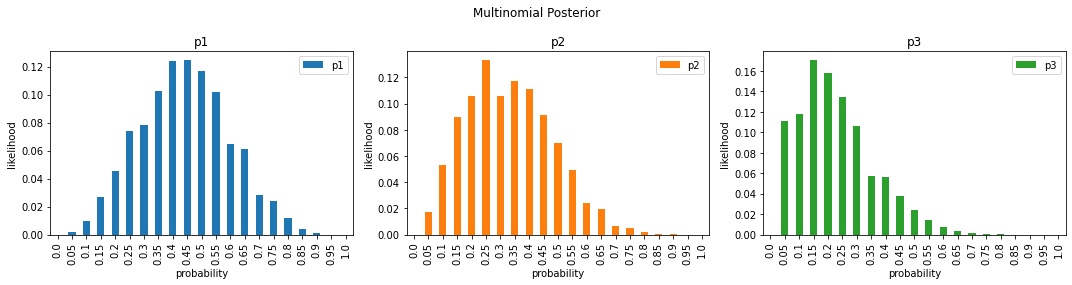

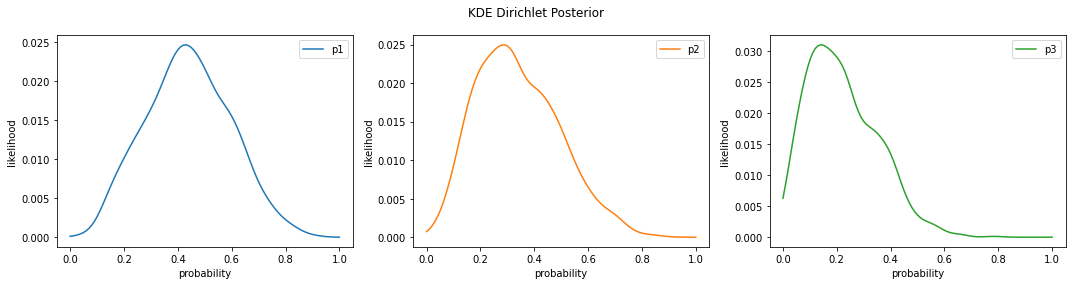

In [8]:
from scipy.stats import multinomial, dirichlet, gaussian_kde
np.random.seed(12345)

data = 3, 2, 1
n = np.sum(data)

# let's build the hypothesis space
available_ps = np.linspace(0, 1, 21).round(2)

mesh = np.meshgrid(available_ps, available_ps, available_ps)  # a 21x21x21 array

cols = ["p1", "p2", "p3"]

bt = pd.DataFrame({col: array.ravel() for col, array in zip(cols, mesh)})

# Exclude all the rows that do not sum 1
exact_rows = bt[cols].sum(axis=1) == 1  # 225 out of 9261
bt = bt[exact_rows]

bt["likes"] = multinomial.pmf(data, n, bt[cols])
bt["posterior"] = bt.likes / bt.likes.sum()

# Extract the marginals
marginals_df = pd.DataFrame({col: bt.groupby(col).posterior.sum() for col in cols})
[QuantitiesOfInterest(marginals_df[col]).run() for col in cols]
print(50 * '*')
print("Dirichlet Approach")

# Now the dirichlet approach
hs = np.linspace(0, 1, 101)
data = np.array(data) + 1
post = dirichlet(data)
samples = post.rvs(1000)
kdes = np.array([gaussian_kde(s).pdf(hs) for s in samples.T])

kde_marginals_df = pd.DataFrame(data=kdes.T, index=hs, columns=cols)
kde_marginals_df[cols] /= kde_marginals_df[cols].sum()
[QuantitiesOfInterest(kde_marginals_df[col]).run() for col in cols]


# plot everything
marginals_df[cols].plot(kind="bar",
    subplots=True, layout=(1, 3), figsize=(15, 4),
    xlabel="probability", ylabel="likelihood", title="Multinomial Posterior"
);
kde_marginals_df[cols].plot(
    subplots=True, layout=(1, 3), figsize=(15, 4),
    xlabel="probability", ylabel="likelihood", title="KDE Dirichlet Posterior"
);

# For some reason, pandas was not able to plot lines and bars in the same plot. If I ever
# want that, a workaround could be write it in pure matplotlib. For the time being, above
# is good enough
# fig, ax = plt.subplots()
# k = marginals_df
# ax.bar(k.index, k["p1"], width=.03, color="C1", alpha=.8);
# ax.plot(k.index, k.dp1, color="black")

